In [1]:
import numpy as np
import pandas as pd
import os
from ete3 import Tree

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import matplotlib.pyplot as plt
import seaborn as sns

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
do_weighted = False
networks_dir = "../../../data/networks/all/"
network_types = ["binary", "weighted", "binarized_weighted"]

relevant_features = {"standardized_partner.diversity": "Shannon diversity",
                     "standardized_d": "Specialization index d'",
                     "standardized_normalised.degree": "Normalized degree",
                     "standardized_weighted.betweenness":  "Betweeness",
                     "standardized_weighted.closeness": "Closeness",
                     "standardized_hubbiness_score": "Hub score"}
classification_db_path = "../../../data/name_resolution/rankedlineage.dmp"
name_resolution_path = "../../../data/name_resolution/resolved_plant_names.csv"
tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
species_features_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"

In [3]:
species_tree = Tree(tree_path)
species_features = pd.read_csv(species_features_path)

In [9]:
species_features = species_features.rename(columns={"mapped_name_x": "mapped_name"})

In [10]:
species_to_ploidy = species_features.set_index("mapped_name")["is_polyploid"]

In [11]:
for leaf in species_tree.get_leaves():
    leaf.add_feature("is_polyploid", species_to_ploidy.get(leaf.name, np.nan))

In [19]:
species_features["network_path"] = species_features.apply(lambda rec: f"{networks_dir}{rec.network_type}/{rec.network_index}.csv", axis=1)

In [21]:
species_features_by_network = species_features.groupby(["network_index", "network_type", "network_id", "network_path"])

In [22]:
def get_nearest_pd_neighbors(network_df: pd.DataFrame) -> list:
    network_plants = network_df.mapped_name.tolist()
    network_polyploids = network_df.loc[network_df.is_polyploid == 1].mapped_name.tolist()
    network_diploids = network_df.loc[network_df.is_polyploid == 0].mapped_name.tolist()
    if len(network_polyploids) == 0 or len(network_diploids) == 0:
        return []
    network_pairs = []
    for polyploid in network_polyploids:
        min_diploid, min_dist = np.nan, float("inf")
        for diploid in network_diploids:
            dist = species_tree.get_distance(polyploid, diploid)
            if dist < min_dist:
                min_dist=dist
                min_diploid=diploid
        network_pairs.append((polyploid, min_diploid))
    return network_pairs
    
nearest_network_pd_pairs = species_features_by_network.parallel_apply(get_nearest_pd_neighbors)

In [23]:
def get_nearest_dd_neighbors(network_df: pd.DataFrame) -> list:
    network_plants = network_df.mapped_name.tolist()
    network_diploids = network_df.loc[network_df.is_polyploid == 0].mapped_name.tolist()
    network_pairs = []
    for i in range(len(network_diploids)-1):
        min_diploid, min_dist = np.nan, float("inf")
        for j in range(i+1, len(network_diploids)):
            dist = species_tree.get_distance(network_diploids[i], network_diploids[j])
            if dist < min_dist:
                min_dist=dist
                min_diploid=network_diploids[j]
        network_pairs.append((network_diploids[i], min_diploid))
    return network_pairs

nearest_network_dd_pairs = species_features_by_network.parallel_apply(get_nearest_dd_neighbors)

In [24]:
nearest_network_pd_pairs = nearest_network_pd_pairs.reset_index().rename(columns={0: "pair"})
nearest_network_pd_pairs["pair_type"] = "pd"
nearest_network_dd_pairs = nearest_network_dd_pairs.reset_index().rename(columns={0: "pair"})
nearest_network_dd_pairs["pair_type"] = "dd"

nearest_network_pairs = pd.concat([nearest_network_pd_pairs, nearest_network_dd_pairs])

In [25]:
nearest_network_pairs = nearest_network_pairs.explode("pair")

In [26]:
nearest_network_pairs = nearest_network_pairs.loc[nearest_network_pairs.pair.notna()]

In [27]:
def get_paired_diff(pair: tuple, network_id: str) -> float:
    try:
        pair_data = species_features.loc[(species_features.network_id == network_id) &
                                         (species_features.mapped_name.isin(list(pair)))].set_index("mapped_name")[list(relevant_features.keys())].transpose()
        pd_diffs = abs(pair_data[pair[0]]-pair_data[pair[1]])
    except Exception as e:
        print(f"error= {e}\nnetwork_id={network_id}\npair={pair}")
        return np.nan
    return list(pd_diffs)

nearest_network_pairs[[f"{f}_diff" for f in relevant_features]] = nearest_network_pairs.parallel_apply(lambda record: get_paired_diff(pair=record.pair, network_id=record.network_id), result_type="expand", axis=1)

In [28]:
nearest_network_pairs["phylogenetic_dist"] = nearest_network_pairs.pair.parallel_apply(lambda pair: species_tree.get_distance(pair[0], pair[1]))

In [66]:
classification_db = pd.read_csv(classification_db_path, sep="\t")
classification_db = classification_db[[c for c in classification_db.columns if "|" not in c]]
classification_db.columns = ["tax_id","tax_name","species","genus","family","order","class","phylum","kingdom","superkingdom"]
for c in set(classification_db.columns)-{"tax_id"}:
    classification_db[c] = classification_db[c].apply(lambda s: s.lower() if type(s) == str else s)
classification_db = classification_db.query("kingdom == 'viridiplantae'")

/tmp/ipykernel_17289/2808606918.py:1: DtypeWarning: Columns (4,6,8,10,12,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  classification_db = pd.read_csv(classification_db_path, sep="\t")


In [ ]:
classification_db.dropna().head()

,tax_id,tax_name,species,genus,family,order,class,phylum,kingdom,superkingdom
1995388,2873799,tetraselmis helgolandica var. tsingtaoensis,tetraselmis helgolandica,tetraselmis,chlorodendraceae,chlorodendrales,chlorodendrophyceae,chlorophyta,viridiplantae,eukaryota
1995687,2081502,neochlorosarcina negevensis f. ferruginea,neochlorosarcina negevensis,neochlorosarcina,chlorosarcinaceae,chlorosarcinales,chlorophyceae,chlorophyta,viridiplantae,eukaryota
1995769,327065,brachiomonas submarina var. pulsifera,brachiomonas submarina,brachiomonas,chlamydomonadaceae,chlamydomonadales,chlorophyceae,chlorophyta,viridiplantae,eukaryota
1995825,1034611,chlamydomonas hydra var. micropapillata,chlamydomonas hydra,chlamydomonas,chlamydomonadaceae,chlamydomonadales,chlorophyceae,chlorophyta,viridiplantae,eukaryota
1995842,1035565,chlamydomonas moewusii var. microstigmata,chlamydomonas moewusii,chlamydomonas,chlamydomonadaceae,chlamydomonadales,chlorophyceae,chlorophyta,viridiplantae,eukaryota


In [ ]:
name_resolution = pd.read_csv(name_resolution_path)
orig_to_resolved = name_resolution.dropna(subset=["resolved_name"]).set_index("original_name")["resolved_name"].to_dict()

In [38]:
nearest_network_pairs = nearest_network_pairs.loc[nearest_network_pairs.pair.notna()]

In [39]:
nearest_network_pairs = nearest_network_pairs.loc[~nearest_network_pairs.pair.str.contains("nan,", na=False)]
nearest_network_pairs = nearest_network_pairs.loc[~nearest_network_pairs.pair.str.contains(",nan", na=False)]

In [40]:
def get_resolved_pair(pair: tuple) -> tuple:
    try:
        member1 = orig_to_resolved.get(pair[0].replace("_"," "), np.nan)
        member2 = orig_to_resolved.get(pair[1].replace("_"," "), np.nan)
        return (member1, member2)
    except Exception as e:
        return np.nan

nearest_network_pairs["resolved_pair"] = nearest_network_pairs.pair.parallel_apply(get_resolved_pair)

In [83]:
classification_db.genus.dropna().unique()

array(['chloroparvula', 'chloropicon', 'prasinocladus', ...,
       'zygnemopsis', 'zygogonium', 'fottea'], dtype=object)

In [90]:
increasing_taxonomic_levels = ["species","genus","family","order","class","phylum","kingdom","superkingdom"]

def get_shared_taxonomic_level(pd_pair: tuple) -> str:
    if pd.isna(pd_pair[0]) or pd.isna(pd_pair[1]):
        return np.nan
    if pd_pair[0].split(" ")[0] == pd_pair[1].split(" ")[0]:
        return "genus"
    classification_data = classification_db.loc[classification_db.tax_name.isin([item.replace("_", " ") for item in pd_pair if type(item) == str])]
    if classification_data.shape[0] < 2:
        return np.nan
    for level in increasing_taxonomic_levels:
        level_data = classification_data[level].dropna().unique()
        if len(level_data) == 1:
            return level
    return np.nan

In [91]:
nearest_network_pairs["shared_taxonomic_level"] = nearest_network_pairs.resolved_pair.parallel_apply(get_shared_taxonomic_level)

In [92]:
nearest_network_pairs.loc[nearest_network_pairs.shared_taxonomic_level.isna(), "shared_taxonomic_level"] = nearest_network_pairs.loc[nearest_network_pairs.shared_taxonomic_level.isna(), "pair"].parallel_apply(get_shared_taxonomic_level)

In [93]:
relevant_nearest_network_pairs = nearest_network_pairs.loc[nearest_network_pairs.shared_taxonomic_level.isin(increasing_taxonomic_levels[:increasing_taxonomic_levels.index("family")+1])]

In [94]:
print(f"# pairs = {nearest_network_pairs.shape[0]:,}")
print(f"# pairs in the same family or below = {np.round(relevant_nearest_network_pairs.shape[0] / nearest_network_pairs.shape[0]*100, 2)}% ({relevant_nearest_network_pairs.shape[0]:,})")

# pairs = 4,429
# pairs in the same family or below = 39.35% (1,743)


In [96]:
repeated_pairs = relevant_nearest_network_pairs.groupby("pair")["network_id"].count().sort_values(ascending=False).reset_index().rename(columns={"network_id": "repeats"})
repeated_pairs

,pair,repeats
0,"(trifolium_repens, trifolium_pratense)",67
1,"(lotus_corniculatus, trifolium_pratense)",31
2,"(heliomeris_multiflora, erigeron_speciosus)",27
3,"(erigeron_speciosus, heterotheca_villosa)",20
4,"(heterotheca_villosa, solidago_multiradiata)",14
...,...,...
955,"(eupatorium_chinense, aster_glehnii)",1
956,"(eupatorium_chinense, eupatorium_lindleyanum)",1
957,"(eupatorium_lindleyanum, lactuca_indica)",1
958,"(eupatorium_perfoliatum, eupatorium_serotinum)",1


In [97]:
relevant_nearest_network_pairs[["member1", "member2"]] = relevant_nearest_network_pairs.parallel_apply(lambda x: [item.capitalize().replace("_", " ") for item in x.pair], axis=1, result_type="expand")

/tmp/ipykernel_17289/3730873135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_nearest_network_pairs[["member1", "member2"]] = relevant_nearest_network_pairs.parallel_apply(lambda x: [item.capitalize().replace("_", " ") for item in x.pair], axis=1, result_type="expand")
/tmp/ipykernel_17289/3730873135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_nearest_network_pairs[["member1", "member2"]] = relevant_nearest_network_pairs.parallel_apply(lambda x: [item.capitalize().replace("_"

In [98]:
relevant_nearest_network_pairs.to_csv(f"../../../data/statistical_analysis/species_level/pair_data_on_{'un' if not do_weighted else ''}weighted_networks.csv")

# show pd pair type differences

In [99]:
relevant_nearest_network_pairs = pd.read_csv(f"../../../data/statistical_analysis/species_level/pair_data_on_{'un' if not do_weighted else ''}weighted_networks.csv")

In [100]:
fontsize=16
import matplotlib 
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize)
matplotlib.rcParams.update({'font.size': fontsize})

relevant_features_cols = list(relevant_features.keys())
relevant_nearest_network_pairs = relevant_nearest_network_pairs.sort_values("pair_type", ascending=True)
relevant_nearest_network_pairs.pair_type = relevant_nearest_network_pairs.pair_type.str.upper()

ValueError: Could not interpret input 'horn_index'

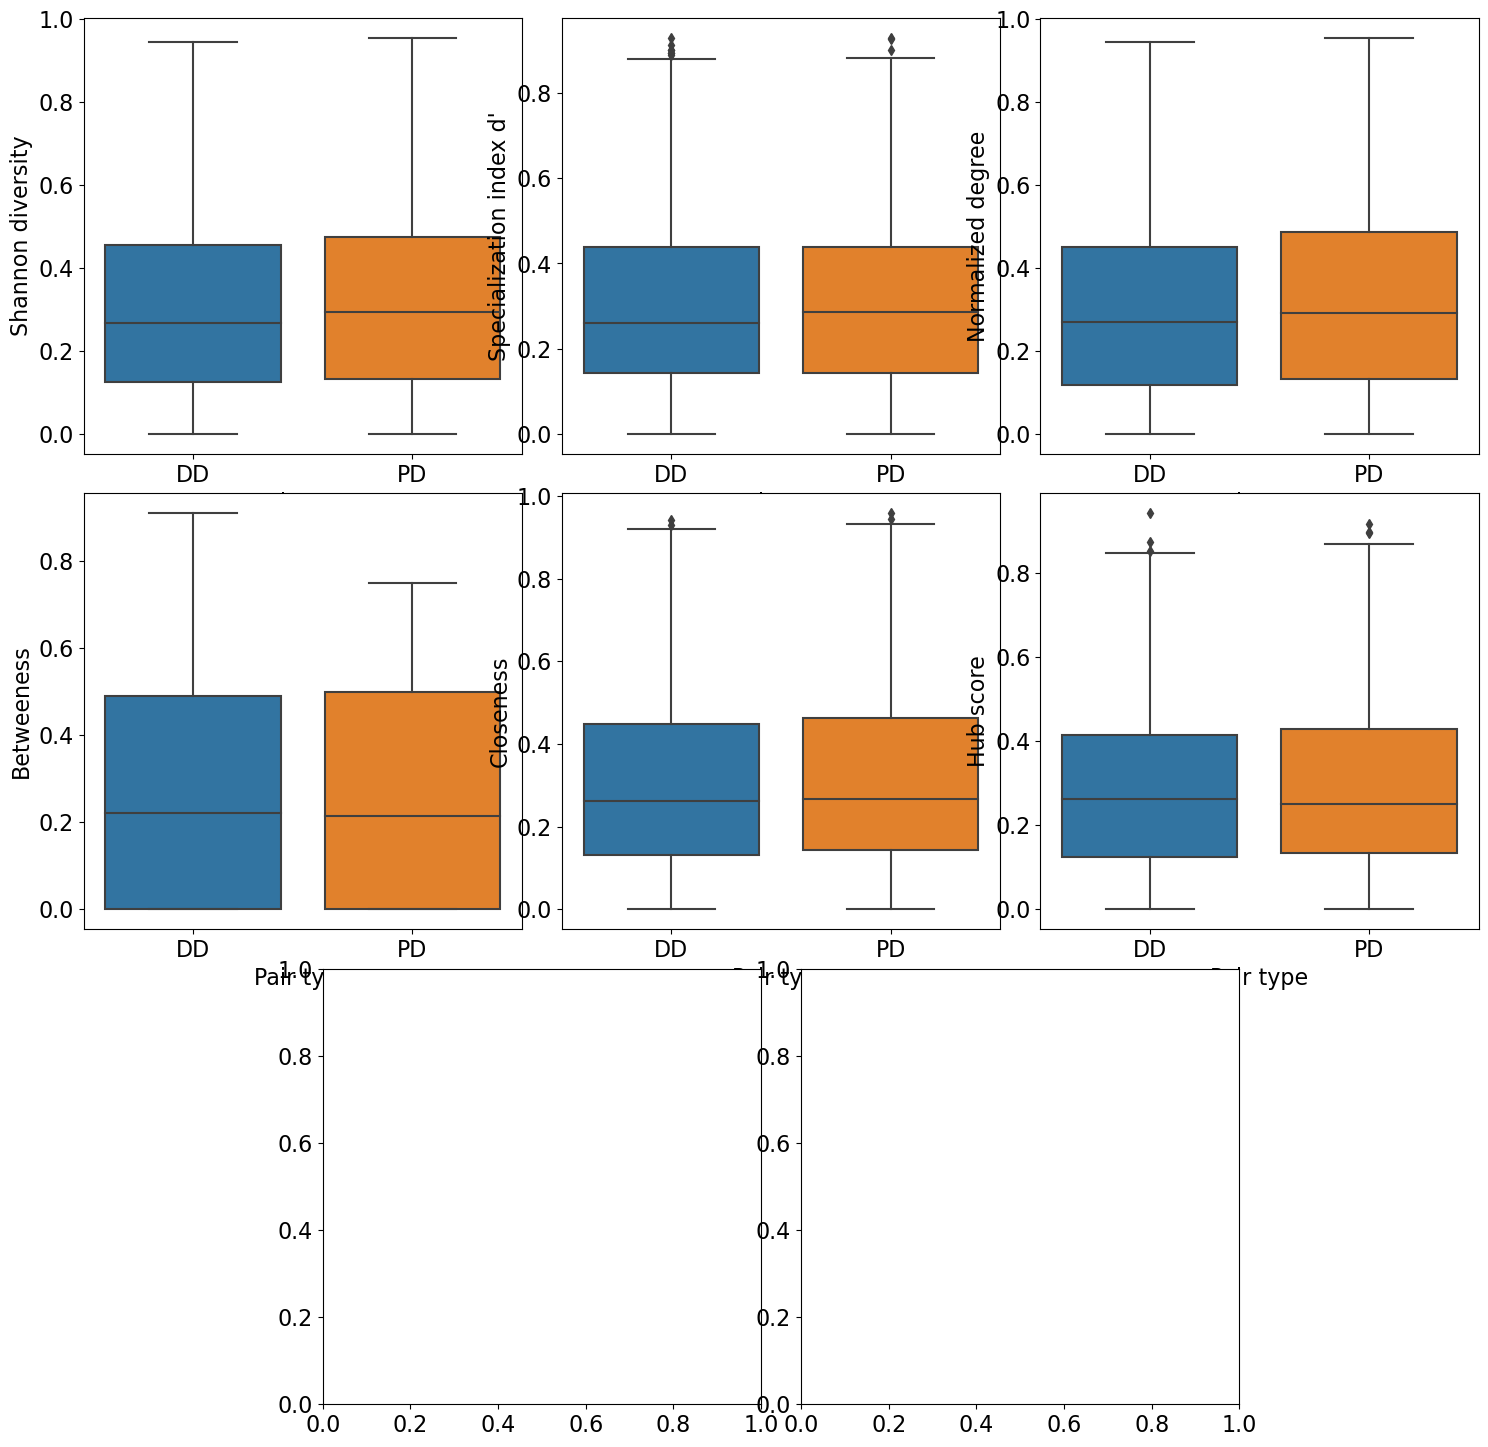

In [101]:
fig = plt.figure(figsize=(3*6,3*6))  
axes = []
axes.append(plt.subplot2grid((6, 6), (0, 0), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (0, 2), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (0, 4), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (2, 0), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (2, 2), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (2, 4), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (4, 1), colspan=2, rowspan=2))
axes.append(plt.subplot2grid((6, 6), (4, 3), colspan=2, rowspan=2))


# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3*5,3*5))

for i in range(len(relevant_features_cols)):
    f = relevant_features_cols[i]
    ax = axes[i] #//3][i % 3]
    sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"{f}_diff", ax=ax)
    ax.set_ylabel(f"{relevant_features[f]}")
    ax.set_xlabel("Pair type")
    # ax.set_ylim((-0.1,1))

i += 1    
ax = axes[i]
sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"horn_index", ax=ax)
ax.set_ylabel(f"Morista-Horn index")
ax.set_xlabel("Pair type")
# ax.set_ylim((-0.1,1.1))
i += 1

ax = axes[i]
sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"frac_shared_modules", ax=ax)
ax.set_ylabel(f"Shared modules fraction")
ax.set_xlabel("Pair type")
# ax.set_ylim((-0.1,1.1))

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'binary' if not do_weighted else 'weighted'}.jpeg")

In [47]:
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(3*6,2*6))  

# for i in range(len(relevant_features_cols)):
#     f = relevant_features_cols[i]
#     ax = axes[i//3][i % 3]
#     sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"{f}_diff", ax=ax)
#     ax.set_ylabel(f"{relevant_features[f]}")
#     ax.set_xlabel("Pair type")
#     ax.set_ylim((-0.1,1))

# fig.tight_layout()
# fig.savefig(f"../../../data/figures/fig4_{'binary' if not do_weighted else 'weighted'}.jpeg")

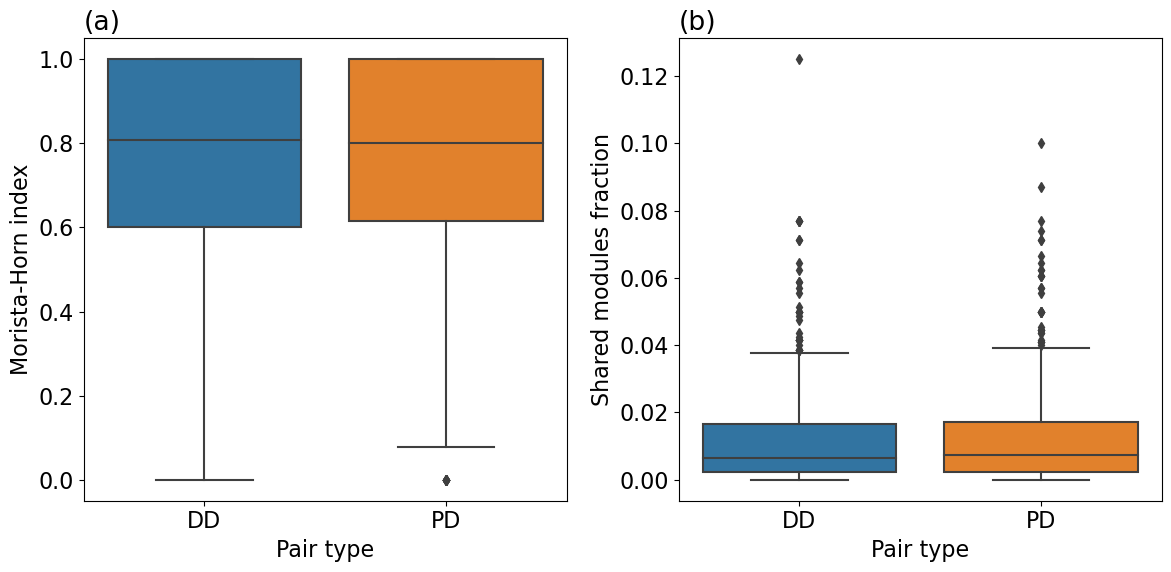

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*6,1*6))  

ax = axes[0]
sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"horn_index", ax=ax)
ax.set_ylabel(f"Morista-Horn index")
ax.set_xlabel("Pair type")
ax.set_title("(a)", loc="left")


ax = axes[1]
sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"frac_shared_modules", ax=ax)
ax.set_ylabel(f"Shared modules fraction")
ax.set_xlabel("Pair type")
ax.set_title("(b)", loc="left")



fig.tight_layout()
fig.savefig(f"../../../data/figures/fig2_{'binary' if not do_weighted else 'weighted'}.jpeg")